In [1]:
import numpy as np
import swyft
import pylab as plt
import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, Nbins = 100, sigma = 0.2):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.y = np.linspace(-1, 1, Nbins)
        self.sigma = sigma

    def calc_m(self, z):
        m = np.ones_like(self.y)*z[0] + self.y*z[1] + self.y**2*z[2]
        return m

    def build(self, graph):  # the print statements are for illustration only
        print("--- Building graph!")
        z = graph.node('z', lambda: np.random.rand(3)*2 - 1)
        m = graph.node('m', self.calc_m, z)
        x = graph.node('x', lambda m: m + np.random.randn(self.Nbins)*self.sigma, m)
        print("--- x =", x)
        print("--- m =", m)
        print("--- z =", z)

In [4]:
sim = Simulator()
samples = sim.sample(10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

--- Building graph!
--- x = Node('x', <function Simulator.build.<locals>.<lambda> at 0x793bed127600>, (Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x793bfa330200>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x793bed1276a0>, ()),)),))
--- m = Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x793bfa330200>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x793bed1276a0>, ()),))
--- z = Node('z', <function Simulator.build.<locals>.<lambda> at 0x793bed1276a0>, ())


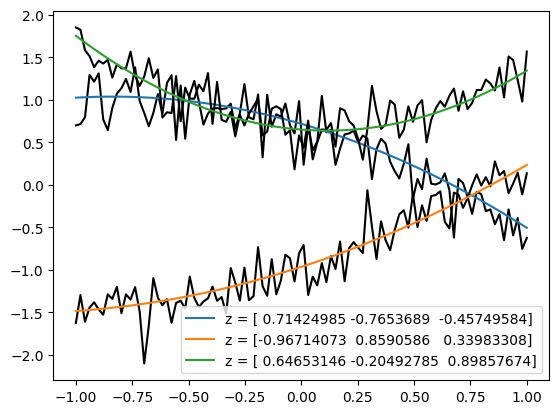

In [5]:
for i in [5, 2, 101]:
    plt.plot(sim.y, samples['x'][i], color='k')
    plt.plot(sim.y, samples['m'][i], label = "z = "+str(samples['z'][i]))
plt.legend();


# Zarr

In [1]:
import numpy as np
import pylab as plt
import torch
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, Nbins = 100, sigma = 0.2):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.y = np.linspace(-1, 1, Nbins)
        self.sigma = sigma

    def calc_m(self, z):
        m = np.ones_like(self.y)*z[0] + self.y*z[1] + self.y**2*z[2]
        return m

    def build(self, graph):  # the print statements are for illustration only
        z = graph.node('z', lambda: np.random.rand(3)*2 - 1)
        m = graph.node('m', self.calc_m, z)
        x = graph.node('x', lambda m: m + np.random.randn(self.Nbins)*self.sigma, m)

In [4]:
sim = Simulator()
shapes, dtypes = sim.get_shapes_and_dtypes()
print("shapes:", shapes)
print("dtypes:", dtypes)

shapes: {'z': (3,), 'm': (100,), 'x': (100,)}
dtypes: {'z': dtype('float32'), 'm': dtype('float32'), 'x': dtype('float32')}


In [5]:
store = swyft.ZarrStore("./example_zarr_store")
store.init(10000, 64, shapes, dtypes)  

In [ ]:
store.simulate(sim, batch_size = 1000,)  # This function can be run in parallel in many threads, if the store is full, it will do nothing


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
dm = swyft.SwyftDataModule(store, batch_size = 32)


In [8]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Linear(100, 10)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 10, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        f = self.embedding(A['x'])
        logratios = self.logratios(f, B['z'])
        return logratios

trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/export/home/vgiusepp/miniconda3

Sanity Checking: 0it [00:00, ?it/s]

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:217: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  rank_zero_warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor

Training: 0it [00:00, ?it/s]

[rank0]:[W411 14:45:11.301433322 reducer.cpp:1400] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[rank1]:[W411 14:45:11.301790084 reducer.cpp:1400] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch

Reloading best model: /export/home/vgiusepp/Odisseo/notebooks/dev/swyft/lightning_logs/version_0/checkpoints/epoch=14-step=3750.ckpt
Reloading best model: /export/home/vgiusepp/Odisseo/notebooks/dev/swyft/lightning_logs/version_0/checkpoints/epoch=14-step=3750.ckpt
Reloading best model: /export/home/vgiusepp/Odisseo/notebooks/dev/swyft/lightning_logs/version_0/checkpoints/epoch=14-step=3750.ckpt
Reloading best model: /export/home/vgiusepp/Odisseo/notebooks/dev/swyft/lightning_logs/version_0/checkpoints/epoch=14-step=3750.ckpt
Reloading best model: /export/home/vgiusepp/Odisseo/notebooks/dev/swyft/lightning_logs/version_0/checkpoints/epoch=14-step=3750.ckpt
Reloading best model: /export/home/vgiusepp/Odisseo/notebooks/dev/swyft/lightning_logs/version_0/checkpoints/epoch=14-step=3750.ckpt
Reloading best model: Reloading best model:/export/home/vgiusepp/Odisseo/notebooks/dev/swyft/lightning_logs/version_0/checkpoints/epoch=14-step=3750.ckpt 
/export/home/vgiusepp/Odisseo/notebooks/dev/swy

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur